In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as snsx
import math
%matplotlib inline

#cv
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐

#### path

In [2]:
org_img_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/'

In [3]:
file_list = os.listdir(org_img_path)
file_list.sort()
file_list = file_list[1:]
list_file = []
for i in file_list:
    list_file.append(org_img_path+i)
list_file.sort()
# list_file

#### 테스트

#### 사용자함수 

In [4]:
#이미지 수 확인하기
def count_img(path):
    data_path = os.path.join(path, '*g')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1)
        img_list.append(img)
    print('이미지수',len(img_list))

In [5]:
#이미지 불러오기
def get_img(path):
    data_path = os.path.join(path, '*g')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1)
        img_list.append(img)
#     print('이미지수',len(img_list))
#     print('show(get_img(list_file[1])[0]) 식으로 이미지 불러와서 img로 저장')
    
    return img_list
    
# data_img = get_img(list_file[2])
# show(img_list[1])

In [6]:
#이미지 함수
def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

In [7]:
#masking, return 까먹지 말기 흑흑 
def get_mask(img):
#     img = cv2.imread(img_path+"/org001.jpg")
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    # show(img)

    # #블러 02
    # #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    # show(img)
    # #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask

#     show(mask)
    #그 다음에 가지고 있는 이미지 모두 마스크 처리 --> 오래걸림

In [8]:
def mask_for_center(img):
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    
    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask

In [9]:
#img_cropping 
def get_cropped_mask(img, mask):
    """
    마스크를 기준으로 경계선을 찾아 위/왼/오른쪽을 자루는 함수로서
    img = original image
    mask = bit_img
    cropped_img = 원본 이미지에서 마크된 영역을 갖는 부분 반환
    """
    
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_.shape
    
    #마스크 기준으로 위/왼/오른쪽 경계선 찾기(숫자로 확인 가능)
    mask_list = mask.tolist()
    
    #테두리가 흰색인 경우를 고려해서, 테두리에서 5% 지점부터 경계점 찾기 시작
    #경계점은 중간 부분(30~70%)에서 검은색(0)을 벗어난 지점을 기준으로 함
    #위쪽
    for y in range(int(height*0.05), height): #마스크이미지에서, 일반 이미지의 5%이상의 지점에서 
    #가로는 30%-70%까지가 0보다 클때 (마스크의 max값이 - 그 범위에 1(흰색)이 있을때)
        if max(mask[y,int(width*0.3):int(width*0.7)]) >0:
        #총 mask 이미지에서, 일반이미지에서 5%더한 값을 뺌
            start_y = y-int(height*0.05)
            break
    
    #왼쪽 start point
    for x in range(int(width*0.05),width):
        if max(mask[x,int(height*0.3):int(height*0.7)]) >0:
            start_x = x-int(width*0.05)
            break

    # #오른쪽, stop, -1,-1(오른쪽에서 왼쪽으로)
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break

    #경계선 기준으로 이미지와 마스크 자름
    img_ = img_[start_y:,start_x:end_x]
    mask = mask[start_y:,start_x:end_x]

    cropped_mask_img = cv2.bitwise_and(img_, mask)
    
    return cropped_mask_img

In [10]:
def wrist_cut(img):
    height = img.shape[0]
    width = img.shape[1]

    #이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
    start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
    index = 0
    k = 10 #10개 행씩 평균 구함
    while True:
        pixel_lower = img[start-k*(index+1):start-k*index,:].mean()
        pixel_upper = img[start-k*(index+2):start-k*(index+1),:].mean()
        if pixel_upper - pixel_lower > 0:
            end_y = start-k*(index+1)
            break
        index += 1

    img = img[:end_y]
    return img

In [11]:
def get_center(img):
    mask = mask_for_center(img)
    res, thresh = cv2.threshold(mask, mask.mean(), 255, cv2.THRESH_BINARY)

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    center = cX, cY
    return center

In [12]:
def get_finger_point(img):
    #손가락포인트
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(max_cnt, returnPoints = False)
    defects = cv2.convexityDefects(max_cnt, hull)

    start_list = []
    far_list = []
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start = tuple(max_cnt[s][0])
        end = tuple(max_cnt[e][0])
        far = tuple(max_cnt[f][0])
        far_list.append(far)

        ##중지 
        for i in far_list:
            far_list.sort(key= lambda x:x[1])
            top = far_list[0]
            tX, tY = top
#             mask = mask_for_center(img)
            cX, cY = get_center(img)
#             cv2.circle(img, top, 5, (2, 255, 180),10)
            
    #새끼 손가락        
    far_list.sort(key= lambda x:x[0])
    pinky_list = []
    for i in far_list:
        if i[1] < cY and i[0] < cX:
            pinky_list.append(i)
    pinky_list.sort(key= lambda x:x[0])
    pinky = pinky_list[0]
    pX, pY = pinky
#     cv2.circle(img, pinky, 5, (2, 255, 180),10)

    # 엄지손가락
    far_list.sort(key= lambda x:x[0])
    thumbs = far_list[-1]
    thX, thY = thumbs
#     cv2.circle(img, thumbs, 5, (2, 255, 180),10)
    
    return top, pinky, thumbs

In [13]:
#중지기준 rotation
def middle_rotation(img):
    cX, cY = get_center(img)
    top, pinky, thumbs = get_finger_point(img)
    tX, tY = top
    angle = math.degrees(math.atan2(cY-tY, cX-tX))
    img = ndimage.rotate(img, angle-90)#시계방향
    return img

In [14]:
#엄지기준 rotation
def thumbs_rotation(img):
    cX, cY = get_center(img)
    top, pinky, thumbs = get_finger_point(img)
    thX, thY = thumbs
    angle = math.degrees(math.atan2(cY-thY, cX-thX))
    img = ndimage.rotate(img, angle-90)#시계방향
    return img

In [15]:
#새끼손가락 기준 rotation
def pinky_rotation(img):
    cX, cY = get_center(img)
    top, pinky, thumbs = get_finger_point(img)
    pX, pY = pinky
    angle = math.degrees(math.atan2(cY-pY, cX-pX))
    img = ndimage.rotate(img, angle-90)#시계방향
    return img

In [16]:
def rotation_cut(img):
    ret, th = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    th_l = th.tolist()
    cut_index = 0
    if th_l[0][0] == 0 or th_l[0][-1] == 0:
        for i in reversed(range(len(th_l))):
            if th_l[i].count(255) > 0:
                cut_index = i

    img = img[cut_index:]
    return img

In [17]:
def center_img(img):
    imgY, imgX = img.shape[:2]
    imgY = int((imgY)/2)
    imgX = int(imgX/2)
    
    return imgY, imgX

In [18]:
#중지자르기
def middle_cut(img):
    top, pinky, thumbs = get_finger_point(img)
    tX, tY = top
    imgY, imgX = center_img(img)
    middle_cut =img[0:imgY, tX-150:tX+200]
    middle_cut = cv2.resize(middle_cut,(100,500), cv2.INTER_AREA)
    return middle_cut

In [19]:
#엄지자르기
#img[y:y, x:x]
def thumbs_cut(img):
    imgY, imgX = center_img(img)
    thumbs_cut =img[0:imgY-70, imgX:imgX+1300]
    thumbs_cut = cv2.rotate(thumbs_cut, cv2.ROTATE_90_CLOCKWISE)
    thumbs_cut = cv2.resize(thumbs_cut,(100,500), cv2.INTER_AREA)
    return thumbs_cut

In [20]:
#새끼손가락
def pinky_cut(img):
    imgY, imgX = center_img(img)
    pinky_cut =img[0:imgY-100, imgX-400:imgX]
    pinky_cut = cv2.resize(pinky_cut,(100,500), cv2.INTER_AREA)
    return pinky_cut

#### 최종함수

In [21]:
def get_middle_finger(img):
    #마스크처리
    mask = get_mask(img)
    
    #마스크에 맞춰 손윤곽 자르기 여기서 grayscale로 변환됨
    img = get_cropped_mask(img, mask)

    #손목 위 자르기
    img = wrist_cut(img)
    mask = mask_for_center(img)

#     #센터점 구하기
#     center = get_center(mask)

#     #손가락포인트구하기
#     top, pinky, thumbs = get_finger_point(img)

    #중지기준 rotation
    img = middle_rotation(img)

    #상위에 맞춰 자르기
    img = rotation_cut(img)

#     #이미지 중앙값
#     imgY, imgX = center_img(img)
    
    #middle_cut + resize
    middle_cut_img = middle_cut(img)
    return middle_cut_img

In [22]:
def get_thumbs_finger(img):
    
    #마스크처리
    mask = get_mask(img)
    
    #마스크에 맞춰 손윤곽 자르기 여기서 grayscale로 변환됨
    img = get_cropped_mask(img, mask)

    #손목 위 자르기
    img = wrist_cut(img)
    mask = mask_for_center(img)

#     #센터점 구하기
#     center = get_center(mask)

    #손가락포인트구하기
#     top, pinky, thumbs = get_finger_point(img)

    #엄지기준 rotation
    img = thumbs_rotation(img)

    #상위에 맞춰 자르기
    img = rotation_cut(img)

#     #이미지 중앙값
#     imgY, imgX = center_img(img)
    
    #thumbs_cut + resize
    thumbs_cut_img = thumbs_cut(img)
    return thumbs_cut_img

In [23]:
def get_pinky_finger(img):
    
    #마스크처리
    mask = get_mask(img)
    
    #마스크에 맞춰 손윤곽 자르기 여기서 grayscale로 변환됨
    img = get_cropped_mask(img, mask)

    #손목 위 자르기
    img = wrist_cut(img)
    mask = mask_for_center(img)

    #엄지기준 rotation
    img = pinky_rotation(img)

    #상위에 맞춰 자르기
    img = rotation_cut(img)

    #thumbs_cut + resize
    pinky_cut_img = pinky_cut(img)
    return pinky_cut_img

#### 저장

#### test

<IPython.core.display.Javascript object>

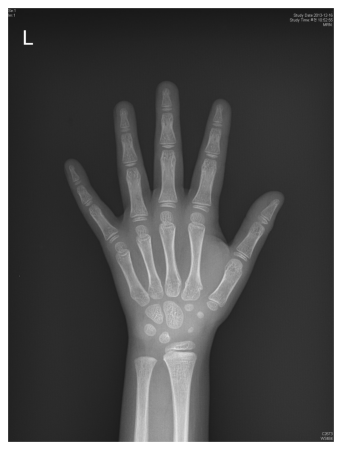

In [26]:
img = get_img(list_file[9])[8]
show(img)

<IPython.core.display.Javascript object>

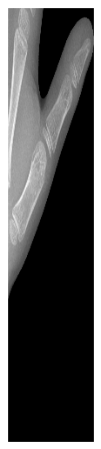

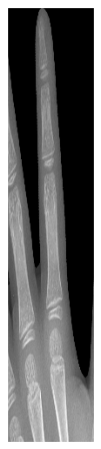

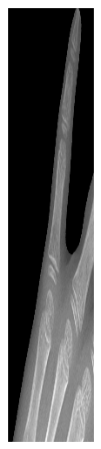

In [24]:
img = get_img(list_file[9])[8]
show
show(get_thumbs_finger(img))
show(get_middle_finger(img))
show(get_pinky_finger(img))